# Twiiter Project

In [1]:
import pandas as pd
import numpy as mp
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import xgboost as xgb
from wordcloud import WordCloud
from sklearn import model_selection
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

Lets look at the data

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
print(train_df.shape)
print(test_df.shape)

(7613, 5)
(3263, 4)


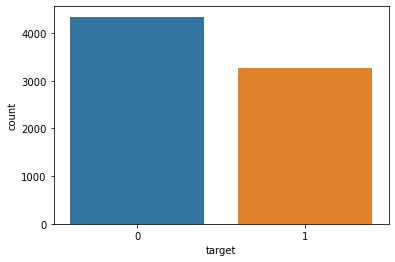

In [5]:
sns.countplot(x='target',data = train_df)

looks like there are more disaster tweets

In [6]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
id             0
keyword       26
location    1105
text           0
dtype: int64


In [ ]:
# remove columns with to many null values
percent = train_df.isnull().sum()/train_df.isnull().count().sort_values(ascending = False)
percent
# DROP LOCATION 
train_df = train_df.drop(['location'],axis = 1)
test_df = test_df.drop(['location'],axis = 1)

In [ ]:
train_df['keyword'] = train_df['keyword'].fillna('None')
test_df['keyword'] = test_df['keyword'].fillna('None')

In [8]:
def apost(text):
    text = text.lower()
    text = re.sub(r"they're","they are",text)
    text = re.sub(r"aren't","are not",text)
    text = re.sub(r"haven't","have not",text)
    text = re.sub(r"can't","can not",text)
    text = re.sub(r"don't","do not",text)
    text = re.sub(r"I'll","I will",text)
    text = re.sub(r"I've","I have",text)
    text = re.sub(r"you're","you are",text)
    text = re.sub(r"won't","will not",text)
    text = re.sub(r"we're","we are",text)
    text = re.sub(r"didn't","did not",text)
    text = re.sub(r"wasn't","was not",text)
    text = re.sub(r"ablaze","a blaze",text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
train_df['text'] = train_df['text'].apply(lambda x: apost(x))
test_df['text'] = test_df['text'].apply(lambda x: apost(x))

expanded some of the words to help the algorithm

In [9]:
train_df.head()

,id,keyword,location,text,target
31,48,ablaze,Birmingham,bbcmtd wholesale markets a blaze,1
32,49,ablaze,Est. September 2012 - Bristol,we always try to bring the heavy metal rt,0
33,50,ablaze,AFRICA,africanbaze breaking newsnigeria flag set a bl...,1
34,52,ablaze,"Philadelphia, PA",crying out for more set me a blaze,0
35,53,ablaze,"London, UK",on plus side look at the sky last night it was...,0


In [10]:
def remove_punc(text):
    text = text.lower()
    translator = str.maketrans(' ', ' ', string.punctuation)
    return text.translate(translator)
train_df['text'] = train_df['text'].apply(lambda x: remove_punc(x))
test_df['text'] = test_df['text'].apply(lambda x: remove_punc(x))

removed unneccessary punctuation to clean the tweets. Also helps when the words are tokenized

In [11]:
train_df.head()

,id,keyword,location,text,target
31,48,ablaze,Birmingham,bbcmtd wholesale markets a blaze,1
32,49,ablaze,Est. September 2012 - Bristol,we always try to bring the heavy metal rt,0
33,50,ablaze,AFRICA,africanbaze breaking newsnigeria flag set a bl...,1
34,52,ablaze,"Philadelphia, PA",crying out for more set me a blaze,0
35,53,ablaze,"London, UK",on plus side look at the sky last night it was...,0


Text(0.5, 1.0, 'keywords with low pct of disaster')

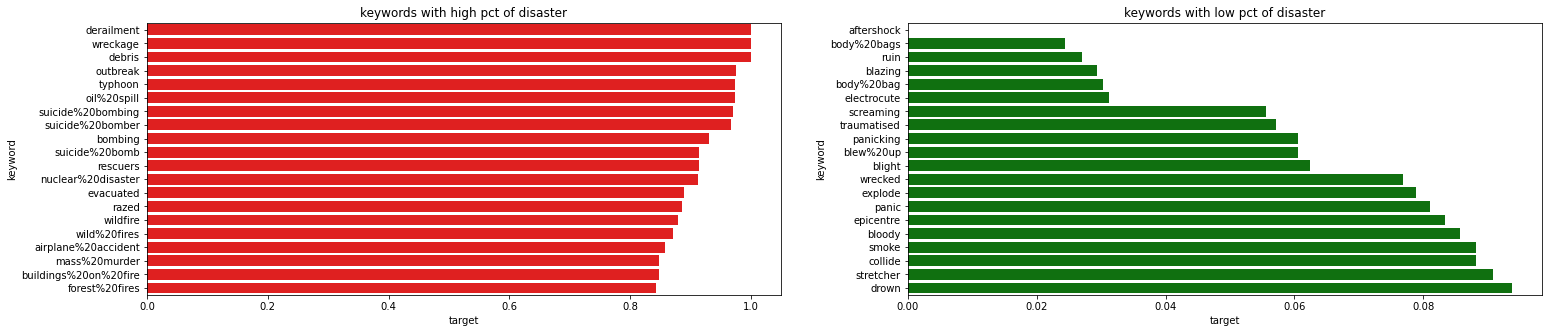

In [15]:
top_dt = train_df.groupby('keyword').mean()['target'].sort_values(ascending = False).head(20)
top_nd = train_df.groupby('keyword').mean()['target'].sort_values(ascending = True).head(20)
plt.figure(figsize = (25,5))
plt.subplot(121)
sns.barplot(top_dt, top_dt.index, color = 'red')
plt.title('keywords with high pct of disaster')
plt.subplot(122)
sns.barplot(top_nd, top_nd.index, color = 'green')
plt.title('keywords with low pct of disaster')

In [19]:
# for line in train_df['text']:
#     line = line.split()
#     for word in line:
#         if "'" in word:
#             print(word)


In [21]:
train  = train_df
test  = test_df
train.head()

,id,keyword,text,target
31,48,ablaze,bbcmtd wholesale markets a blaze,1
32,49,ablaze,we always try to bring the heavy metal rt,0
33,50,ablaze,africanbaze breaking newsnigeria flag set a bl...,1
34,52,ablaze,crying out for more set me a blaze,0
35,53,ablaze,on plus side look at the sky last night it was...,0


In [22]:
len_tweets = len(train[train['target']==1])
real_tweet = len_tweets/train.shape[0] * 100
false_tweet = 100-real_tweet
print('real tweets pct:',real_tweet)
print('false tweets pct:',false_tweet)

real tweets pct: 42.75688559322034
false tweets pct: 57.24311440677966


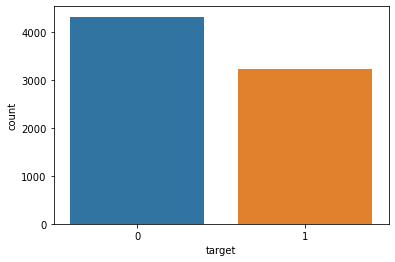

In [23]:
# sns.countplot(x='target',data = train)

In [25]:
# removed words that dont add value to the tweet
def remove_stop(text):
    words = [w for w in text.split() if w not in stopwords.words('english')]
    return words

train_df['text'] = train_df['text'].apply(lambda x: remove_stop(x))
test_df['text'] = test_df['text'].apply(lambda x: remove_stop(x))

In [26]:
# change words to their basic form
lem = WordNetLemmatizer()
def lem_word(x):
    return [lem.lemmatize(w) for w in x]

train_df['text'] = train_df['text'].apply(lambda x: lem_word(x))
test_df['text'] = test_df['text'].apply(lambda x: lem_word(x))

In [27]:
def combine(text):
    combined = " ".join(text)
    return combined
train_df['text'] = train_df['text'].apply(lambda x: combine(x))
test_df['text'] = test_df['text'].apply(lambda x: combine(x))

In [28]:
# bag of words have limitation so I decided to not go ahead with this method
count_vect = CountVectorizer()
train_vector = count_vect.fit_transform(train_df['text'])
test_vector = count_vect.transform(test_df['text'])


In [29]:
# This method purpose is to measure the importants of 
# each word which tends to be better that Bag of Words
tfidf = TfidfVectorizer(min_df = 1,max_df = .2, ngram_range = (1,2))
train_tfidf = tfidf.fit_transform(train_df['text'])
test_tfidf = tfidf.transform(test_df['text'])

## Machine Learning


In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import svm

used gridsearch to get optimzed parameters

In [31]:
# pipeline = Pipeline([('tfidf',TfidfVectorizer()),('svm', svm.SVC(kernel = 'linear'))])
# parameters = {'tfidf__min_df':[1,2,3],'tfidf__max_df':[.1,.25,.5,],
#              'tfidf__ngram_range': [(1,1),(1,2),(1,3)]}
# gs_tune = GridSearchCV(pipeline,param_grid = parameters,cv = 10, scoring = 'f1')
# gs_tune.fit(train_df['text'],train_df['target'])


In [32]:
# gs_tune.best_params_

In [33]:
# mnb = MultinomialNB(alpha = 2)
# scores_vector = model_selection.cross_val_score(mnb,train_vector,train_df['target'],
#                                                cv =10, scoring = 'f1')
# print('score:',scores_vector)
# scores_tfidf = model_selection.cross_val_score(mnb,train_tfidf,train_df['target'],
#                                                cv = 10, scoring = 'f1')
# print('score tfidf:', scores_tfidf)

## SVM

From past experience and readings I know that svm is usually does well with nlp tasks.

In [35]:
clf_svm = svm.SVC(kernel = 'linear')
clf_svm.fit(train_tfidf,train_df['target'])
y_pred = clf_svm.predict(test_tfidf)

In [36]:
submission = pd.DataFrame({'Id':test_df['id'],'target': y_pred})
submission.to_csv('submission1.csv',index = False)